## sigMF IQ noise testing

In [5]:
import os
import torch #, torchvision
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from torch import istft
global GPU, n_fft
global Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a
a = 1
var_noise = 8.78e-09
GPU = 0
Fs = 1000000*25
n_fft = 1024*25
fft = 1024*25
plt.style.use('default')
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [6]:
# %matplotlib notebook
# %matplotlib inline

In [7]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [8]:
path_noise = "/home/david/sigMF_ML/RF/noise/"
path = "/home/david/sigMF_ML/RF/RF_class/" # ACE
os.chdir(path_noise)
print(path)

/home/david/sigMF_ML/RF/RF_class/


In [9]:
!python3 /home/david/sigMF_ML/gnuradio/record_live2.py

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
OOOOOOOOOOOO

In [11]:
os.chdir(path_noise)
db = np.fromfile("noise.sigmf-data", dtype="float32")

#### torch GPU Cuda stft

In [12]:
def gpu(db):
    I = db[0::2]
    Q = db[1::2]
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    print('I shape = ', I_stft.shape, 'Q shape = ', Q_stft.shape)
    torch.cuda.empty_cache()
    return I_stft, Q_stft

In [13]:
def gpu_test_file(db):
    print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=fft, hop_length=fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=fft, hop_length=fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    Z_stft = torch.cat((I_stft,Q_stft),2)
    Z_stft = torch.cat((Z_stft[fft//2:,:,:],Z_stft[:fft//2,:,:]))
    print('gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[:fft//2,:,:]
    return Z_stft # Returning only 4D tensor

#### FOR plotting spectrum: one sided must be false on torch.stft

In [18]:
def gpu_plot(db):
    I = db[0::2]
    Q = db[1::2]
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    print('gpu_plot X shape =', X_stft.shape)
    torch.cuda.empty_cache()
    return X_stft

In [19]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live2.py

### GPU Timing: first time slowest

In [20]:
stft_gpu = gpu_plot(db)
stft2_gpu = gpu(db)

gpu_plot X shape = torch.Size([25600, 9766])
I shape =  torch.Size([25600, 9766, 2]) Q shape =  torch.Size([25600, 9766, 2])


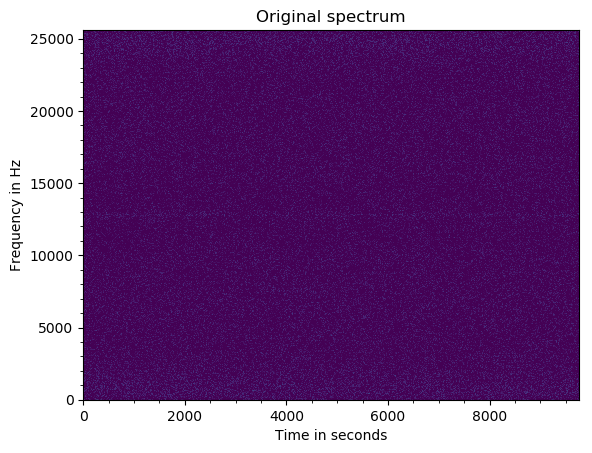

In [21]:
os.chdir(path)
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_gpu.cpu()+1e-15)), aspect='auto', origin='lower', vmin=-70, vmax=5)
# plt.imshow(test_noise, aspect='auto', origin='lower', vmin=-70, vmax=5)
title = "Original spectrum"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig3.savefig('full_spectrum_sum_diff.pdf', format="pdf")
plt.show()

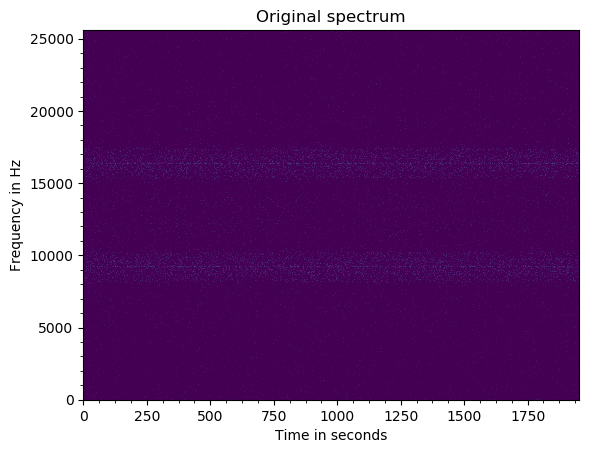

In [494]:
os.chdir(path)
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
plt.imshow(20*np.log10(np.abs(I_stft[:,:,0].cpu()+1e-15)), aspect='auto', origin='lower', vmin=-70, vmax=5)
# plt.imshow(20*np.log10(np.abs(I_stft[:,:,0].cpu()+1e-15)), aspect='auto', origin='lower')
# plt.imshow(test_noise, aspect='auto', origin='lower', vmin=-70, vmax=5)
title = "Original spectrum"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig3.savefig('full_spectrum_I_ch0.pdf', format="pdf")
plt.show()

In [378]:
test = (((var_noise)**0.5)*torch.randn(224, 224))

In [381]:
test[:3]

tensor([[ 1.5028e-05,  1.3991e-05,  9.9705e-05,  2.3501e-05, -8.6327e-05,
         -1.0306e-04, -5.5319e-05, -6.9426e-05, -6.3131e-05,  1.0588e-05,
         -7.5424e-05,  8.2920e-05,  1.2519e-05, -7.7681e-05, -7.5000e-06,
          8.2448e-06, -1.2013e-06, -1.3974e-05, -1.3111e-04,  6.2359e-05,
          1.1915e-04, -5.0765e-05,  1.7979e-05,  4.7019e-05, -1.2114e-04,
          6.0704e-06, -1.3771e-04,  1.1629e-04, -7.0173e-05,  7.4908e-05,
         -8.4693e-05, -1.0168e-05, -3.4782e-06,  2.1851e-04,  2.0827e-05,
          8.5656e-06,  4.9456e-05, -5.3678e-05,  4.0539e-05,  1.1122e-04,
          7.3001e-05, -1.3076e-04, -3.5589e-05,  1.5701e-04,  6.5123e-05,
          1.9414e-04,  1.0437e-04,  1.4155e-04, -1.0328e-06,  1.0735e-04,
         -2.6666e-05,  8.3810e-05,  1.5235e-04,  1.8346e-04, -1.0681e-05,
          1.1003e-04, -1.9912e-04, -9.3121e-05,  7.6272e-05, -1.2842e-04,
          1.0437e-04, -4.1172e-05, -1.7657e-04, -3.3835e-05, -2.6971e-05,
         -8.4519e-05, -4.4485e-05, -6.

#### Inverse stft 

In [25]:
def ISTFT(db):
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    Z = istft(db, n_fft=n_fft, hop_length=w//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    torch.cuda.empty_cache()
    return Z

In [30]:
I_stft, Q_stft = gpu(db)
# c1 = torch.FloatTensor(a).uniform_(r1_c1, r2_c1)
# c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
c1 = 1 # 10 = 10 dB increase in noise floor, 30 = 20dB, 100 = 30dB, 500 = 45dB 1000 = 50dB
c2 = 10e1 # 10e1 = 10 dB increase in noise floor, 10e2 = 20dB, 10e3 = 30dB, 10e4 = 40dB 10e5 = 50dB

I shape =  torch.Size([25600, 9766, 2]) Q shape =  torch.Size([25600, 9766, 2])


In [31]:
I_stft = I_stft.cpu() + (((var_noise*c2)**0.5)*torch.randn([25600, 9766, 2])*c1)  
Q_stft = Q_stft.cpu() + (((var_noise*c2)**0.5)*torch.randn([25600, 9766, 2])*c1)  

I = ISTFT(I_stft.cuda(GPU))
Q = ISTFT(Q_stft.cuda(GPU))
I = I.detach().cpu().numpy()
Q = Q.detach().cpu().numpy()
end = len(I)*2
IQ_SVD = np.zeros(len(I)*2) # I and Q must be same length
IQ_SVD[0:end:2] = I
IQ_SVD[1:end:2] = Q 
IQ_SVD = IQ_SVD.astype(np.float32).view(np.complex64)

In [32]:
torch.cuda.empty_cache()

### noise injection

### Write reconstructed IQ file to file

In [33]:
os.chdir(path_noise)
from array import array
IQ_file = open("injected_noise.sigmf-data", 'wb')
IQ_SVD.tofile(IQ_file)
IQ_file.close()

In [34]:
10e1

100.0

In [484]:
10e2

1000.0